# Task 2 :  Implement a circuit which returns |00> and |11> with equal probability.

Requirements :
* Circuit should consist only of CNOTs, RXs and RYs.

* Start from all parameters in parametric gates being equal to 0 or randomly chosen.

* You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 
* Simulations must be done with sampling - i.e. limited number of measurements per iteration and noise. 

* Compare the results for different numbers of measurements: 1, 10, 100, 1000. 


Bonus question:
How to make sure you produce state |00>+|11> and not |00>-|11> ?



I am going to implement this circuit using QISkit from IBM. This is my first time using it so this might not be the most optimal implementation. 

In [407]:
import qiskit as q
import numpy as np
import matplotlib as plt
%matplotlib inline 

I will start by building simple version of the circuit and progressively add more features to meet the task requirements. 

A circuit with two quantum register can be build using the QuantumCircuit class.

In [408]:
#Creates a QuantumCirctuit object with 2 qubits.
circ = q.QuantumCircuit(2)

We can visualize the circuit at any time using the draw method.

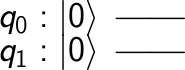

In [409]:
circ.draw()

A state that will only give output of $| 00 \rangle$ or $| 11 \rangle$ will be of the form,

 <center> $|\psi \rangle = \frac{1}{\sqrt 2}\left( |00 \rangle + e^{i\phi} | 11 \rangle \right) $ </center>

A simple circuit that will make the Bell state $\frac{1}{\sqrt 2}\left( |00 \rangle +  | 11 \rangle \right) $ can be constructed by a Hadamard gate and a CNOT gate as follows

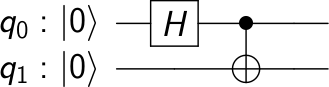

In [410]:
# adds a Hadamard gate to qubiit 0 and a CNOT gate between qubit 0 and 1. 
circ.h(0)
circ.cx(0, 1)

#draws the circuit
circ.draw()

We can check the output of this circuit by simulating it with the statevector simulator in qiskit.Aer.

In [411]:
from qiskit import Aer

In [412]:
# Retrives the backend we want to simulate the output state. 
backend_state = Aer.get_backend('statevector_simulator')

# creates a job and executes the circuit by giving ot to the statevector backend.
job = q.execute(circ, backend_state)

# Retrives the reuslt of the job
result = job.result()

# Show the results
print(result.get_statevector(circ, decimals=3))

[0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j]


The above state is indeed $\frac{1}{\sqrt 2}\left( |00 \rangle +  | 11 \rangle \right) $ as we required.

But the task asks us only to use Rx, Ry and CNOT. To do this we have to recognize that any unitary operation on a qubit can be decompsed into a Rx and Ry rotation upto some phase. In our case the Hadamard has many non-unique decomposition into Rx and Ry gates such as,

<center>$ R_x(\pi ) R_y(\pi / 2 )  = e^{i\pi X/ 2}e^{i\pi Y / 4} = (I \cos \pi/2 + X \sin \pi/2 )(I \cos\pi /4 + Y \sin \pi /4) = \frac{1}{\sqrt 2}(X + XY)  = \frac{1}{\sqrt 2}(X + Z) = H$</center> 

Let's build out circuit again and implement it with Rx and Ry gates this time.

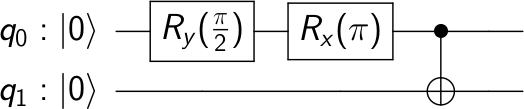

In [413]:
# Bulding circuit with Rx and Ry instead of H
circ = q.QuantumCircuit(2)
circ.ry(np.pi / 2, 0)
circ.rx(np.pi ,0)
circ.cx(0, 1)

circ.draw()

Let's look at the output state once more.

In [414]:
# Run the quantum circuit on a statevector simulator backend
job = q.execute(circ, backend_state)
result = job.result()

# Show the results
print(result.get_statevector(circ, decimals=3))

[0.707+0.j 0.   +0.j 0.   +0.j 0.707+0.j]


We ge the same bell state output as we did when we used the hadamard as expected. But untill now we were using the statevector backend. On a real quantum computer we will only measure out classical bits. So let's simulate this circuit using the qsam simulator. 

First we need to add classical bits to our circuit 

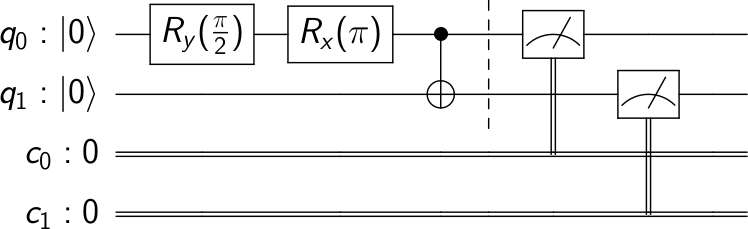

In [415]:
#creates a quantum circuit wtih 2 quantum bits and 2 classical bits.
meas = q.QuantumCircuit(2, 2)
# separates blocks to prevent changes from circuit optimization
meas.barrier(range(2))

# map the quantum measurement to the classical bits
meas.measure(range(2),range(2))

# concatenate the measurement circuit with our orginal circuit.
circ = circ + meas

#draws circuit
circ.draw()

Now let's simulate this circuit and get measurement outcomes using the qsam simulator backend.

In [416]:
backend = Aer.get_backend('qasm_simulator')
results = q.execute(circ, backend, shots = 100).result()
counts = results.get_counts(circ)
display(counts)

{'00': 55, '11': 45}

In [417]:
from qiskit.visualization import plot_histogram

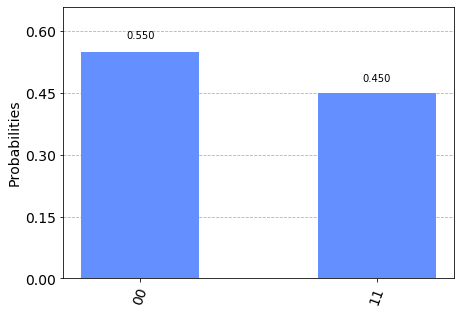

In [418]:
plot_histogram(counts)

We can see that we get outputs 00 and 11 with approximately equal probability. If we improve the number of shots in the quantum simulator the accuracy will improve accordingly for example if do 1000 shots instead of 100,

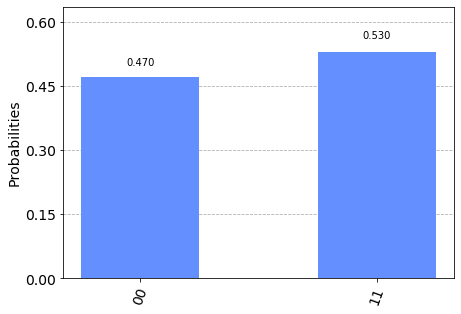

In [419]:
results = q.execute(circ, backend, shots = 100).result()
counts = results.get_counts(circ)
plot_histogram(counts)

However we entered the parameters for the rotations gates by hand. We want to initially set these to be random and use an optimization technique to find the final angles. These angles need not be unique since there are multiple decompositions possible.

We will define a function that takes as inputs the angeles of the roation gates and returns the correct quantum circuit.

In [420]:
def get_circ(params):
    """Takes input of parameters for Rx and Ry gates returns circuit to be optimized."""
    
    theta_x = params[0]
    theta_y = params[1]
    
    qc = q.QuantumCircuit(2)
    qc.ry(theta_y, 0)
    qc.rx(theta_x, 0)
    qc.cx(0, 1)
    
    meas = q.QuantumCircuit(2, 2)
    meas.barrier(range(2))
    
    # map the quantum measurement to the classical bits
    meas.measure(range(2),range(2))
    
    qc = qc + meas
    
    return qc
    

In [421]:
theta_x = np.pi/4 
theta_y = np.pi / 2
qc = get_circ([theta_x, theta_y])

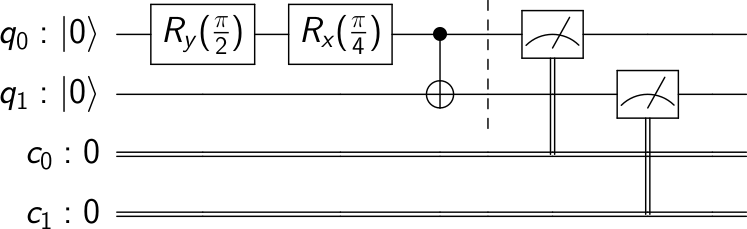

In [422]:
qc.draw()

We will now define the objective function which will run the circuit and return the cost a measure of how far the obtained distribution for the angles specified is from the target distribution.

In [423]:
def objective_function(params):
    """Calculates and returns the distance between the simulated distribution 
    and the target distribution. Note the global constants NUM_SHOTS and TARGET_DIST 
    need to be defined before calling this function."""
    
    # builds the quantum circuit using the angles in params.
    qc = get_circ(params)
    
    # executes the circuit using the qasm simulator
    backend = Aer.get_backend('qasm_simulator')
    results = q.execute(qc, backend, shots = NUM_SHOTS).result()
    counts = results.get_counts(qc)
    
    # Normalises the counts to create an output probability disitrbution 
    output_dist = {key: value / NUM_SHOTS for key, value in counts.items()}
    
    #computes the cost function and returns it
    cost = 0
    for key, value in output_dist.items():
        cost += np.abs(value - TARGET_DIST[key])
        
    return cost
    

We will use the COBYLA optimizer from the aqua package.

In [424]:
from qiskit.aqua.components.optimizers import COBYLA

In [425]:
def find_opt(target, shots):
    
    
    #set up optimizer
    optimizer = COBYLA(maxiter=500, tol=1e-6)

    # Create the initial parameters
    params = np.random.rand(2)
    NUM_SHOTS = shots
    TARGET_DIST = target

    return optimizer.optimize(num_vars=2, objective_function=objective_function, initial_point=params)

    
    

We will now run the simulation for different number of shots.

In [426]:
TARGET_DIST = {'00' : 0.5, '11' : 0.5, '01' : 0, '10' : 0}

ans_list = []
for NUM_SHOTS in [1, 10, 100, 100]:

    opt_out = find_opt(TARGET_DIST, NUM_SHOTS)

    # Obtain the output distribution using the final parameters
    output_qc = get_circ(opt_out[0])
    counts = q.execute(output_qc, backend, shots=NUM_SHOTS).result().get_counts(output_qc)
    output_distr = {key: value / NUM_SHOTS for key, value in counts.items()}
    ans_list.append(counts)

    print("Target Distribution:", TARGET_DIST)
    print("Obtained Distribution:", output_distr)
    print("Output Error (Manhattan Distance):", opt_out[1])
    print("Output Objective Function:", objective_function(opt_out[0]))
    print("Parameters Found:", opt_out[0])
    plot_histogram(counts)

Target Distribution: {'00': 0.5, '11': 0.5, '01': 0, '10': 0}
Obtained Distribution: {'00': 1.0}
Output Error (Manhattan Distance): 0.5
Output Objective Function: 0.5
Parameters Found: [0.65293483 0.36130705]
Target Distribution: {'00': 0.5, '11': 0.5, '01': 0, '10': 0}
Obtained Distribution: {'00': 0.9, '11': 0.1}
Output Error (Manhattan Distance): 0.5
Output Objective Function: 0.6000000000000001
Parameters Found: [0.02295329 0.76783   ]
Target Distribution: {'00': 0.5, '11': 0.5, '01': 0, '10': 0}
Obtained Distribution: {'00': 0.53, '11': 0.47}
Output Error (Manhattan Distance): 0.15999999999999998
Output Objective Function: 0.26
Parameters Found: [1.65052809 1.19968017]
Target Distribution: {'00': 0.5, '11': 0.5, '01': 0, '10': 0}
Obtained Distribution: {'00': 0.51, '11': 0.49}
Output Error (Manhattan Distance): 0.06000000000000005
Output Objective Function: 0.08000000000000002
Parameters Found: [1.3409669  1.27722593]


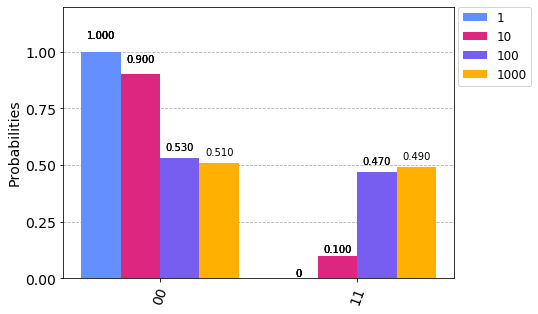

In [427]:
plot_histogram(ans_list, legend =['1', '10', '100', '1000'])

We can see that our estimation improves with the number of shots.

Finally let us add some errors into the model and see how it behaves.

In [428]:
import qiskit.providers.aer.noise as noise

In [429]:
#Add errors to noise model
noise_model = noise.NoiseModel()

In [430]:
def objective_function_noisy(params):
    """Calculates and returns the distance between the simulated distribution 
    and the target distribution. Note the global constants NUM_SHOTS and TARGET_DIST 
    need to be defined before calling this function."""
    
    # builds the quantum circuit using the angles in params.
    qc = get_circ(params)
    
    
    #########################################
    #noise added to the execute now
    #########################################
    # executes the circuit using the qasm simulator 
    backend = Aer.get_backend('qasm_simulator')
    results = q.execute(qc, backend, shots = NUM_SHOTS, noise_model=noise_model).result()
    counts = results.get_counts(qc)
    
    # Normalises the counts to create an output probability disitrbution 
    output_dist = {key: value / NUM_SHOTS for key, value in counts.items()}
    
    #computes the cost function and returns it
    cost = 0
    for key, value in output_dist.items():
        cost += np.abs(value - TARGET_DIST[key])
        
    return cost

In [431]:
def find_opt_noisy(target, shots):
    
    
    #set up optimizer
    optimizer = COBYLA(maxiter=500, tol=1e-6)

    # Create the initial parameters
    params = np.random.rand(2)
    NUM_SHOTS = shots
    TARGET_DIST = target

    return optimizer.optimize(num_vars=2, objective_function=objective_function_noisy, initial_point=params)

    

In [439]:
TARGET_DIST = {'00' : 0.5, '11' : 0.5, '01' : 0, '10' : 0}

ans_list = []
parameter_list = []
for NUM_SHOTS in [1, 10, 100, 100]:

    opt_out = find_opt_noisy(TARGET_DIST, NUM_SHOTS)
    parameter_list.append(opt_out[0])

    # Obtain the output distribution using the final parameters
    output_qc = get_circ(opt_out[0])
    counts = q.execute(output_qc, backend, shots=NUM_SHOTS, noise_model = noise_model).result().get_counts(output_qc)
    output_distr = {key: value / NUM_SHOTS for key, value in counts.items()}
    ans_list.append(counts)

    print("Target Distribution:", TARGET_DIST)
    print("Obtained Distribution:", output_distr)
    print("Output Error (Manhattan Distance):", opt_out[1])
    print("Output Objective Function:", objective_function_noisy(opt_out[0]))
    print("Parameters Found:", opt_out[0])
    plot_histogram(counts)

Target Distribution: {'00': 0.5, '11': 0.5, '01': 0, '10': 0}
Obtained Distribution: {'00': 1.0}
Output Error (Manhattan Distance): 0.5
Output Objective Function: 0.5
Parameters Found: [0.52850552 0.12549371]
Target Distribution: {'00': 0.5, '11': 0.5, '01': 0, '10': 0}
Obtained Distribution: {'00': 0.4, '11': 0.6}
Output Error (Manhattan Distance): 0.19999999999999996
Output Objective Function: 0.8
Parameters Found: [ 1.8207855  -0.11152017]
Target Distribution: {'00': 0.5, '11': 0.5, '01': 0, '10': 0}
Obtained Distribution: {'00': 0.5, '11': 0.5}
Output Error (Manhattan Distance): 0.10000000000000003
Output Objective Function: 0.10000000000000003
Parameters Found: [1.19025203 1.54552706]
Target Distribution: {'00': 0.5, '11': 0.5, '01': 0, '10': 0}
Obtained Distribution: {'00': 0.46, '11': 0.54}
Output Error (Manhattan Distance): 0.12000000000000005
Output Objective Function: 0.15999999999999998
Parameters Found: [1.62950853 1.87193302]


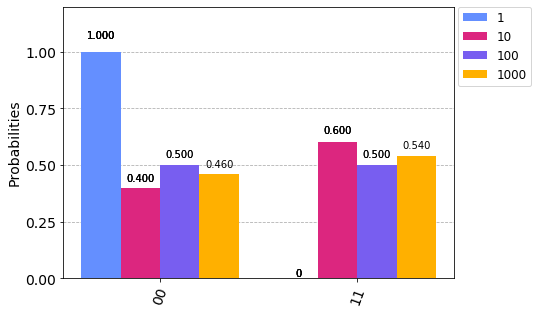

In [440]:
plot_histogram(ans_list, legend =['1', '10', '100', '1000'])

The effect of the noise seems to improve the optimization for 10 shots and create some error in the higher shot values. Maybe because it movies the optimization out of local minimas quickly for low number of shots.

To determine if we made the state $\frac{1}{\sqrt 2}\left( |00 \rangle + | 11 \rangle \right)$ or $\frac{1}{\sqrt 2}\left( |00 \rangle -  | 11 \rangle \right)$?

I could not figure out how to ensure we can ensure the generation of one over the other. The best strategy I could think of was doing a Bell test on the optimized parameters to check which state it is.

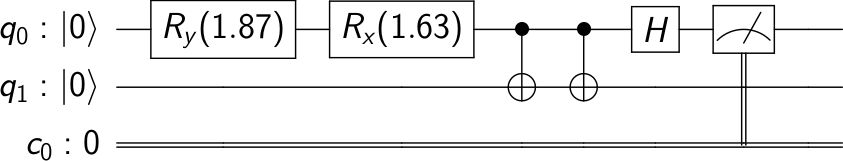

In [455]:
optimized_circ = q.QuantumCircuit(2,1)

optimized_circ.ry(parameter_list[3][1], 0)
optimized_circ.rx(parameter_list[3][0], 0)
optimized_circ.cx(0,1)
optimized_circ.cx(0,1)
optimized_circ.h(0)

optimized_circ.measure([0], [0])
optimized_circ.draw()

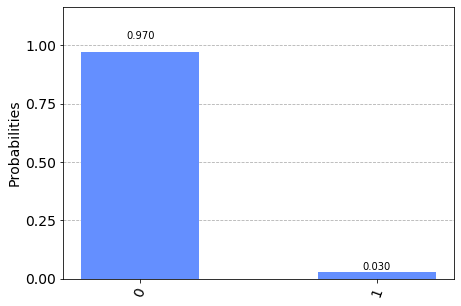

In [457]:
results = q.execute(optimized_circ, backend, shots = 1000).result()
counts = results.get_counts(optimized_circ)
plot_histogram(counts)

This result strongly suggests that we created the $| 00 \rangle + | 11 \rangle$  state.